# Discrete Dynamic Programing

After the previous Value Function Iteration (VFI) notebooks it's time for talking discrete dynamic programming at large.

The setup here is different from the previous problem (see VFI 1.5), where we took a [monte carlo integration](https://en.wikipedia.org/wiki/Monte_Carlo_integration) approach to deal with uncertainty - we took a sample of random numbers (large enough) from the distribution of shocks and then took the mean. That way we approximated the value of the expectation operator (up to an error).

There is another way of taking expectations 

This notebook is to be used after reading the first part (up until *Example: A Growth Model*) of the [quantecon lecture](https://lectures.quantecon.org/py/discrete_dp.html) on dynamic programming. Read it in your own (if you are not seeing this in class) first, making sure you follow fairly well what it says. The more difficult bits (value function interation) should be solid from our previous notebooks.

You'll need numba, so install it now before proceeding. The folowing cell should execute without problems:

In [25]:
from __future__ import division  # Not needed for Python 3.x
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import quantecon as qe
from numba import jit
import emoji # optional, comment out if you like

sns.set_style('whitegrid')
%matplotlib inline

## 1.1 A cookie problem

The aim of this bit is to provide you with a reference guide so you cna implement your own versions in the future.

The problem follows [the growth model example](https://lectures.quantecon.org/py/discrete_dp.html#example-a-growth-model) of quantecon.

Suppose we live in a world where cookies are the only commodity that matters.

Every night, the cookie fairies bring a random ammount of cookies to your door. The amount of cookies ($y$) received is distributed uniformly from 0 to B:

$$ y \sim U[0,B] $$

So chances of getting 5 cookies are the same as taking 0.

You are endowed with a cookie jar that can hold at maximum M cookies.

You wake up in the morning, take your "income" cookies and put them together with your exisiting savings in the jar.

Your goal then is to decide how many cookies out of your income ($y$) you want to save ($a$) and how many you want to consume ($c$) today (so that $y = c+a$). Consumed cookies give you a unitily of $u(c)$ and you discount the future by $\beta$ each period.

Let's make utility exponential for this case so that $u(c)=c^{\alpha}$.

> **Task 1:** Following the [quantecon](https://lectures.quantecon.org/py/discrete_dp.html#example-a-growth-model) exposition, explain with your own words what is the state variable, state space, action space, reward function and transition probabilities. No reading the math, but explaining with words.

> Then use them to add comments to the setting cell below explaining what each line represents.

In [2]:
M=10             # Upper Storage limit of the jar
B=5              # Max amount of cookies in delivery
n = B + M + 1    # Number of possible states (s)
m = M + 1        # Number of posible actions (a, cookies to leave in the jar)
alpha=0.5        # Utility parameter
beta=0.9         # Discount factor

We are going to use discrete markov chains to incorporate the random component of $y$ into our decisions. For that we need to code the matrix algebra version of this problem:

$$ v(s) = \max_a r(s,a) + \beta \sum_{s' \in S}Q(s,a,s') v(s')$$

- $Q$ is going to be a **tri**dimensional matrix that relates states today, actions today and states tomorrow.

- $r(s,a)$ is going to be a matrix of utilitiesvalues, for each state-value pair $(s,a)$: $u(s-a)$. We are going to "cheat" by giving a utility of $-\infty$ to the unfeasible values (say you have 0 cookie in the jar and you receive 1: You can only save either 1 or 0. If you choose to save more then you get minus infinity utility).

That's why we are going to code them in the following way (make sure you understand it):

In [3]:
R = np.empty((n, m))
Q = np.zeros((n, m, n))

Now it is time to fill up the matrices.

> **Task 2:** Complete the code below. You can do this in easy mode (go back to quantecon and copy the bits you need) or in hard mode: pen and paper if needed and coding it by hand.

In [4]:
# Utility function
def u(c, alpha):
    return c**alpha

In [5]:
# Reward matrix
for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = u(s - a, alpha)
        else:
            R[s, a] = -np.inf

In [6]:
# Markow transition matrix
for a in range(m):
    Q[:, a, a:(a + B + 1)] = 1.0 / (B + 1)

We can use the cells below to print the matrices and check we did the right thing.

In [7]:
print R

[[ 0.                -inf        -inf        -inf        -inf        -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 1.          0.                -inf        -inf        -inf        -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 1.41421356  1.          0.                -inf        -inf        -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 1.73205081  1.41421356  1.          0.                -inf        -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 2.          1.73205081  1.41421356  1.          0.                -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 2.23606798  2.          1.73205081  1.41421356  1.          0.
         -inf        -inf        -inf        -inf        -inf]
 [ 2.44948974  2.23606798  2.          1.73205081  1.41421356  1.          0.
         -inf        -inf        -inf        -inf]
 [ 2.64575131  2.44948974  2.23606798  2.          1.7320

In [8]:
print Q

[[[ 0.16666667  0.16666667  0.16666667 ...,  0.          0.          0.        ]
  [ 0.          0.16666667  0.16666667 ...,  0.          0.          0.        ]
  [ 0.          0.          0.16666667 ...,  0.          0.          0.        ]
  ..., 
  [ 0.          0.          0.         ...,  0.16666667  0.          0.        ]
  [ 0.          0.          0.         ...,  0.16666667  0.16666667  0.        ]
  [ 0.          0.          0.         ...,  0.16666667  0.16666667
    0.16666667]]

 [[ 0.16666667  0.16666667  0.16666667 ...,  0.          0.          0.        ]
  [ 0.          0.16666667  0.16666667 ...,  0.          0.          0.        ]
  [ 0.          0.          0.16666667 ...,  0.          0.          0.        ]
  ..., 
  [ 0.          0.          0.         ...,  0.16666667  0.          0.        ]
  [ 0.          0.          0.         ...,  0.16666667  0.16666667  0.        ]
  [ 0.          0.          0.         ...,  0.16666667  0.16666667
    0.16666667]]

 [

Or we can plot them too:

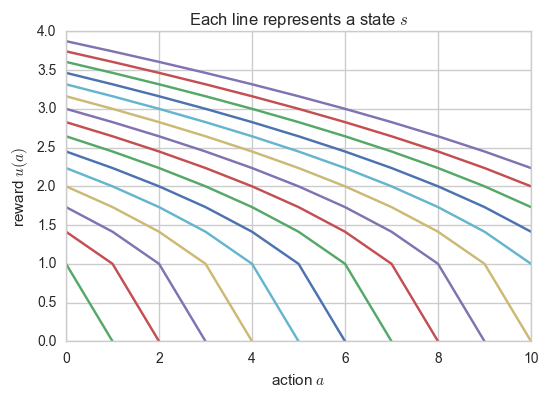

In [9]:
plt.plot(R.T)
plt.xlabel('action $a$')
plt.ylabel('reward $u(a)$')
plt.title('Each line represents a state $s$')
plt.show()

## 1.2 Solving for cookies: home made solution

We could go ahead and use the quantecon package for this problem, but I think it would be more useful if we know what are we doing and code the algorithms ourselves. If you don't feel adventurous you can skip to the next section.

First let's solve it by VFI. We will have:

$$ V_{t+1} = \max_a R + \beta Q V{t}$$

Our algorithm will be as follows:

- We give a initial guess $V_0$ for $V{t}$. We will have a resulting $n$ x $m$ matrix (call it *RQV*)
- For each row of *RQV*, choose the column that gives the maximum value. This is the $\max_a$ step.
- Given this choice, calculate the vector $V{t+1}$ (put all of the maximum values together in one vector)
- Calculate the distance between $V{t+1}$ and $V{t}$
- If this distance is greater than some tolerance, set our guess vector $V{t} = V{t+1}$ and repeat.

Let's do it slowly so we get a grasp of what's going on.

**1** We set our initial guess, a vector of size $n$

In [10]:
v0 = np.ones(n)
v0

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

**2** We compute the implied RQV matrix.

Notive the use of ``np.dot``: if you use ``*`` you get *pointwise* multiplication, we don't want that for $Q$ and $V$, but we want that for $\beta$.

In [11]:
RQV = R + beta*np.dot(Q,v0)
print RQV 

[[ 0.9               -inf        -inf        -inf        -inf        -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 1.9         0.9               -inf        -inf        -inf        -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 2.31421356  1.9         0.9               -inf        -inf        -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 2.63205081  2.31421356  1.9         0.9               -inf        -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 2.9         2.63205081  2.31421356  1.9         0.9               -inf
         -inf        -inf        -inf        -inf        -inf]
 [ 3.13606798  2.9         2.63205081  2.31421356  1.9         0.9
         -inf        -inf        -inf        -inf        -inf]
 [ 3.34948974  3.13606798  2.9         2.63205081  2.31421356  1.9         0.9
         -inf        -inf        -inf        -inf]
 [ 3.54575131  3.34948974  3.13606798  2.9         2.63

**3** We find the column (action) that gives the maximun value of each row (state).

For this we use numpy function maximum, as it allows us to chose the direction (1 for column, 0 for row).

We can also record our choices into a vector (of which lenght?). Call it $p$ for policy.

In [14]:
np.max(RQV,1)

array([ 0.9       ,  1.9       ,  2.31421356,  2.63205081,  2.9       ,
        3.13606798,  3.34948974,  3.54575131,  3.72842712,  3.9       ,
        4.06227766,  4.21662479,  4.36410162,  4.50555128,  4.64165739,
        4.77298335])

In [13]:
np.argmax(RQV,1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [15]:
v1  = np.max(RQV,1)
p1 = np.argmax(RQV,1)

**4** In equilibirum, ``v0=v1``. Let's check the maximum difference between both after one iteration.

In [16]:
np.max(np.abs(v1-v0))

3.7729833462074174

Now that we understand the steps, it's time to implement the algorithm.

> **Task 3:** Code the Value Function Iteration algorithm, following the steps above.

In [17]:
v0 = np.ones(n)
distance = 5
it = 0
while distance > 1e-6:
    it += 1
    Ev1 = R + beta*np.dot(Q,v0)
    v1  = np.max(Ev1,1)
    p1 = np.argmax(Ev1,1)
    distance = np.max(np.abs(v1-v0))
    v0 = v1

print "Done! Distance: {}  Iterations: {}".format(distance,it)

Done! Distance: 9.18105278913e-07  Iterations: 136


If the code worked out correctly, the following cell should give you the answer

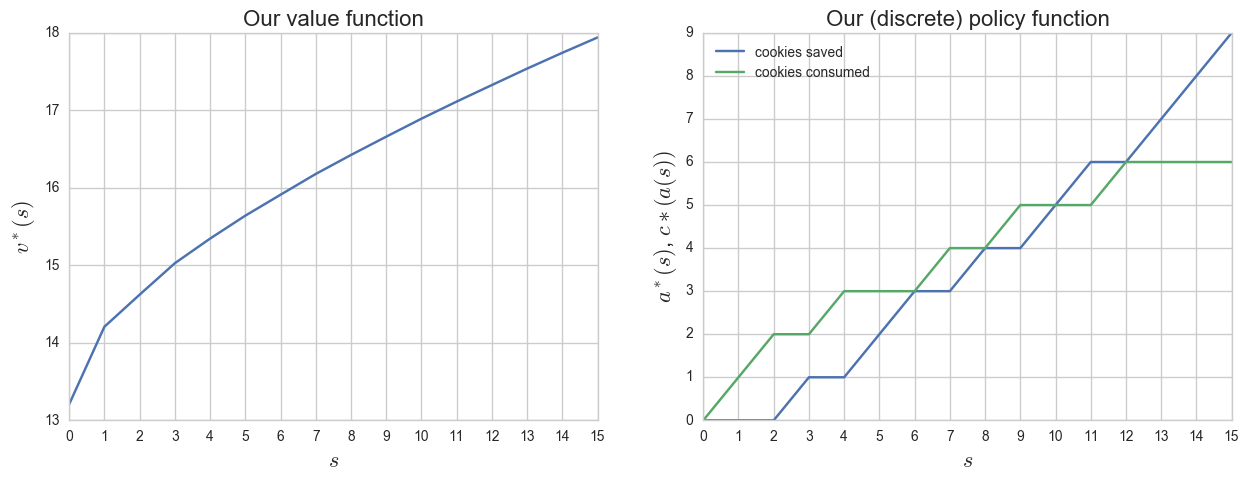

In [18]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(range(n),v1)
plt.xlim(0,15)
plt.xticks(range(0,16))
plt.ylabel('$v^*(s)$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.title('Our value function', fontsize=16)

plt.subplot(122)
plt.plot(range(n),p1, label='cookies saved')
plt.plot(range(n),np.arange(n)-p1, label='cookies consumed')
plt.xlim(0,15)
plt.xticks(range(0,16))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$a^*(s)$, $c^*(a(s))$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best')
plt.show()

plt.show()

## 1.2 Solving for cookies: Quantecon solution

That was fast! But did we got the right answer? Let's check using quantecon's tools.

The following lines create an *instance* (a variable containing a problem) of the ``discreteDP`` class, then solve it.

In [19]:
ddp = qe.markov.DiscreteDP(R, Q, beta)
results = ddp.solve(method='value_iteration')

The variable ``results`` is a dictionary  that stores the output from the algorithm. Call ``.keys()`` to see what it recorded.

In [20]:
results.keys()

['mc', 'v', 'epsilon', 'max_iter', 'sigma', 'num_iter', 'method']

> **Task 4:** Select the right result to store the policy function in ``p_qe`` and the value function ``v_qe``

In [21]:
v_qe = results.v
p_qe = results.sigma

Do we got the right answer?

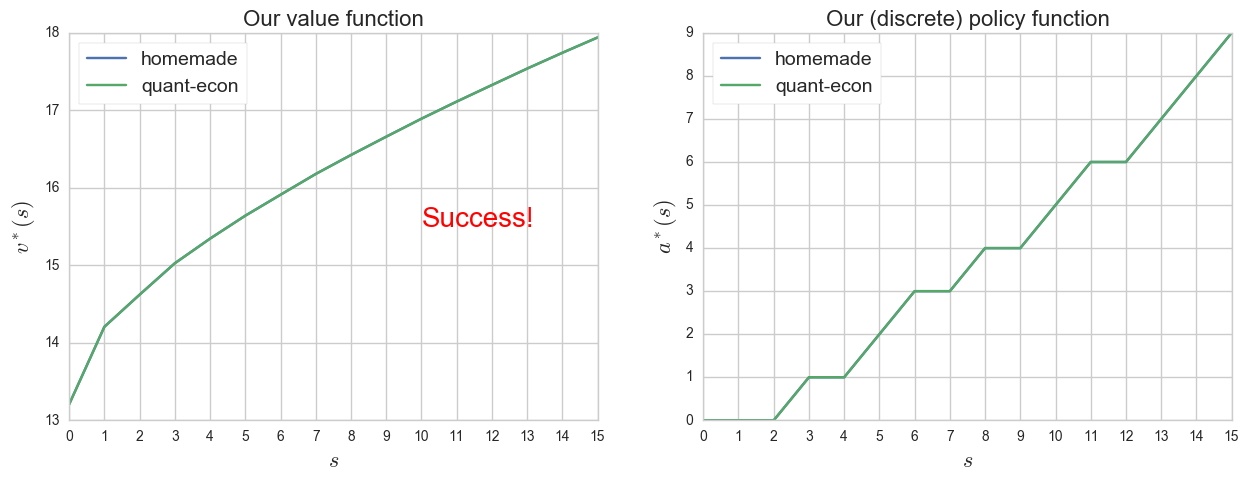

In [43]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(range(n),v1, label='homemade')
plt.plot(range(n),v_qe, label='quant-econ')
plt.xlim(0,15)
plt.xticks(range(0,16))
plt.ylabel('$v^*(s)$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)
plt.annotate('Success!', (10,15.5), fontsize=20, color='red')
plt.title('Our value function', fontsize=16)

plt.subplot(122)
plt.plot(range(n),p1, label='homemade')
plt.plot(range(n),p_qe, label='quant-econ')
plt.xlim(0,15)
plt.xticks(range(0,16))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$a^*(s)$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)

plt.show()

Hurray! But mind you, the routines of the quantecon function are more sophisticated that ours, so they solve the problem faster. Compare the number of iterations it took to get to the answer:

In [44]:
print "Our number of iterations: {}".format(it)
print "QuantEcon number of iterations: {}".format(results.num_iter)

Our number of iterations: 136
QuantEcon number of iterations: 97


## 2. Back to our growth model

Can we use the tools we learnt to get to the same answer we got last week?

This section goes through the answer to the first exercise of the quantecon lecture. But if you are up for a real challenge, try to do it yourself! Note that it is quite hard.

The exercise constitutes and example of how to present a problem in a way you can use the quantecon routine to solve it. Which is, incidentally, what you will end up doing in coding: finding the right tools for your problem and adapting your problem  so you can use them effectively.

The first step is to recode the main parameters (including the capital grid) and the analytical answer. There is no productivity shock.

In [45]:
# Defining Parameters
alpha = 0.65
f = lambda k: k**alpha
u = np.log
beta = 0.95

# Defining grid
grid_max = 2
grid_size = 200
grid = np.linspace(1e-6, grid_max, grid_size)

# Exact solution (for comparison)
ab = alpha * beta
c1 = (np.log(1 - ab) + np.log(ab) * ab / (1 - ab)) / (1 - beta)
c2 = alpha / (1 - ab)

def v_star(k):
    return c1 + c2 * np.log(k)

true_c = (1 - alpha * beta) * grid**alpha

Then let's define our feasible set $A(s)$. This is going to ge all of the combinations of state (capital) and action (consumption) that yield non-negative state tomorrow (capital tomorrow).

We use the ``np.where`` function to locate these values.  ``np.where`` returns two vectors: one with the row indexes and one with the column indexes. For example if our set was:

```
[[0,0,-9],
[0,-1,26]]
```

Then ``np.where`` would return: ``[0,0,1,1],[0,1,0,2]``. The coordinates of all of the points that are greater than 0.

In [46]:
# Consumption matrix, with nonpositive consumption included
As = f(grid).reshape(grid_size, 1) - grid.reshape(1, grid_size)
# size 150x1, 1x150

# State-action indices
s_indices, a_indices = np.where(As > 0)

# Number of state-action pairs
L = len(s_indices)

Of course ``s_indices`` and ``a_indices`` conatin the same number of elements ``L``. You can check what the variables contain using the print cells below:

In [47]:
print As

[[  1.24892541e-04  -9.92535369e-03  -1.99755999e-02 ...,  -1.97977361e+00
   -1.98982386e+00  -1.99987411e+00]
 [  5.02845197e-02   4.02342735e-02   3.01840272e-02 ...,  -1.92961399e+00
   -1.93966423e+00  -1.94971448e+00]
 [  7.89028868e-02   6.88526406e-02   5.88023944e-02 ...,  -1.90099562e+00
   -1.91104587e+00  -1.92109611e+00]
 ..., 
 [  1.55889824e+00   1.54884800e+00   1.53879775e+00 ...,  -4.21000265e-01
   -4.31050511e-01  -4.41100758e-01]
 [  1.56403726e+00   1.55398701e+00   1.54393676e+00 ...,  -4.15861250e-01
   -4.25911497e-01  -4.35961743e-01]
 [  1.56916720e+00   1.55911695e+00   1.54906670e+00 ...,  -4.10731312e-01
   -4.20781558e-01  -4.30831804e-01]]


In [48]:
print s_indices, a_indices

[  0   1   1 ..., 199 199 199] [  0   0   1 ..., 154 155 156]


Makes sense, right?

So what are going to be our R and Q matrices? The ones corresponding to the feasible state-action pairs. For that reason, the reward matrix $R$ is going to be a vector this time (each element corresponding to a state-action) of length $1$x$L$.

Now for $Q$: there is no uncertainty, so $Q$ will map action pairs $As$ to the corresponding level of capital tomorrow. So each row will map each action pair to the state it came from $A(s) \rightarrow s$. This is because as in the no uncertainty case:

$$ V(k) = \max_{k'} {u(k') + \beta V(k')}$$

So it does make sense that the $k'$ in $V(k')$ should be the same as in $V(k)$ with probability 1.

In [55]:
R = u(As[s_indices, a_indices])
Q = np.zeros((L, grid_size))    # creates a 'sparse' matrix, with all zeros

Q[np.arange(L), a_indices] = 1          

Don't worry if it is confusing. This notation is used by the ``DiscreteDP`` class to solve the problem:

In [57]:
ddp2 = qe.markov.DiscreteDP(R, Q, beta, s_indices, a_indices)
results2 = ddp2.solve(method='policy_iteration')
v_qe2 = results2.v               # Value function
p_qe2 = results2.sigma           # Optimal policy (savings)
c_qe2 = f(grid) - grid[p_qe2]    # Optimal consumption

And as you can see, it solves the problem correctly:

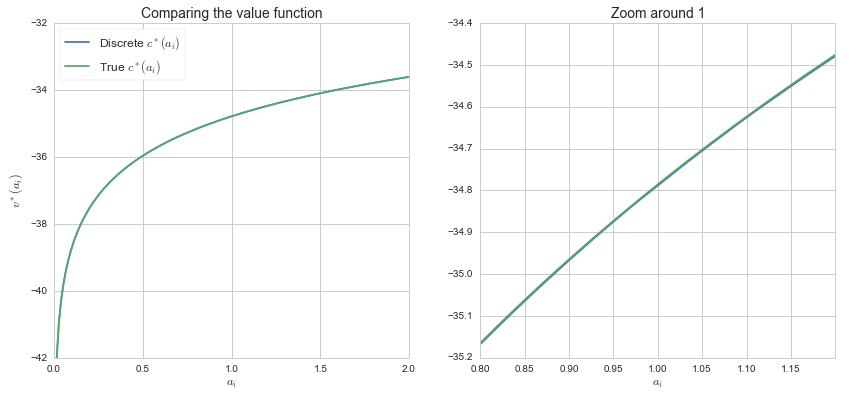

In [30]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(grid,v_qe2, label='Discrete $c^*(a_i)$')
plt.plot(grid,v_star(grid), label='True $c^*(a_i)$')
plt.ylim(-42, -32)
plt.ylabel('$v^*(a_i)$', fontsize=12)
plt.xlabel('$a_i$', fontsize=12)
plt.legend(loc='best',fontsize=12, frameon=True)
plt.title('Comparing the value function', fontsize=14)

plt.subplot(122)
plt.plot(grid,v_qe2, label='Discrete $c^*(a_i)$')
plt.plot(grid,v_star(grid), label='True $c^*(a_i)$')
plt.ylim(-35.2, -34.4)
plt.xlim(0.8,1.2)
plt.xlabel('$a_i$', fontsize=12)
plt.title('Comparing the value function', fontsize=14)
plt.title('Zoom around 1', fontsize=14)

plt.show()

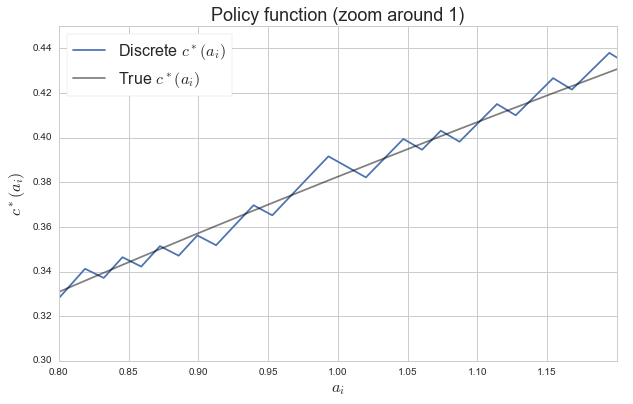

In [31]:
# Zoom in
plt.figure(figsize=(10,6))
plt.plot(grid,c_qe2, label='Discrete $c^*(a_i)$')
plt.plot(grid,true_c, color='black', alpha=0.5, label='True $c^*(a_i)$')
plt.title('Policy function (zoom around 1)', fontsize=18)
plt.xlabel('$a_i$', fontsize=16)
plt.ylabel('$c^*(a_i)$', fontsize=16)
plt.xlim(0.8,1.2)
plt.ylim(0.3,0.45)
plt.legend(loc='best',fontsize=16, frameon=True)
plt.show()

## 3. Take aways and results

As you can see, it can be tricky to work with markov chain transitions, but the speed and accuracy of results is worth it.

From here, I propose you pick up on of the next exercises to do for next session:

1. Implement the policy function iteration to the cookie problem. I haven't had time to talk about it this time, but it is a great opportunity to do so in the next one.

2. Modify the code above to include the innovation as we saw it in VFI 1.5. This is quite a challenge, because it requires first to transform the lognromal shock into a markov transition matrix, and then specify the Q and R matrices correctly. It is great for understanding though, and certainly useful for the future.

3. More fun: Read the [McCall model lecture](https://lectures.quantecon.org/py/mccall_model.html) and add to it assets - that is, a grid for assets and a consumption-saving decision. Compare the wage reservation you get to the 'hand-to-mouth' scenario.

4. Play around risk aversion using different utility functions. Do you get the result you expected?

And after that we will conclude our introduction to dynamic programming.

## Example of 4: Playing with risk aversion

In [3]:
B=50             # Max amount of cookies in delivery
M=500            # Upper Storage limit of the jar
n = B + M + 1    # Number of possible states (s)
m = M + 1        # Number of posible actions (a, cookies to leave in the jar)
alpha=0.5        # Utility parameter
beta=0.9         # Discount factor

R = np.empty((n, m))
Q = np.zeros((n, m, n))

def u(c, a):
    return c**a
for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = u(s - a, alpha)
        else:
            R[s, a] = -np.inf
for a in range(m):
    Q[:, a, a:(a + B + 1)] = 1.0 / (B + 1)

In [33]:
ddp = qe.markov.DiscreteDP(R, Q, beta)
results = ddp.solve(method='policy_iteration')
v_qe = results.v
p_qe = results.sigma

In [5]:
# Redefine utility
def CRRA(c, gamma):
    if c==0:
        return -99999999999
    elif gamma == 1:
        return np.log(c)
    else:
        return ((c**(1-gamma)-1)/(1-gamma))

# Rebuild matrix R
for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = CRRA(s - a, 1)
        else:
            R[s, a] = -np.inf

In [5]:
log_ddp = qe.markov.DiscreteDP(R, Q, beta)
log_results = log_ddp.solve(method='policy_iteration')
log_v = log_results.v
log_p = log_results.sigma

In [6]:
## CRRA       

# Rebuild matrix R
for s in range(n):
    for a in range(m):
        if a <= s:
            R[s, a] = CRRA(s - a, 1.5)
        else:
            R[s, a] = -np.inf

In [7]:
crra_ddp = qe.markov.DiscreteDP(R, Q, beta)
crra_results = crra_ddp.solve(method='policy_iteration')
crra_v = crra_results.v
crra_p = crra_results.sigma

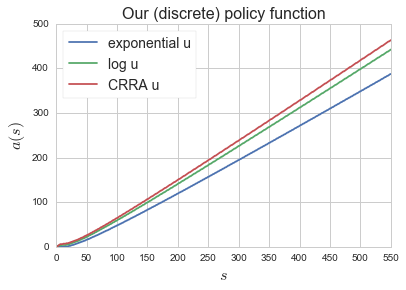

In [38]:
plt.plot(range(n),p_qe, label='exponential u')
plt.plot(range(n),log_p, label='log u')
plt.plot(range(n),crra_p, label='CRRA u')
plt.xlim(0,n-1)
plt.xticks(range(0,600,50))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$a(s)$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)

plt.show()

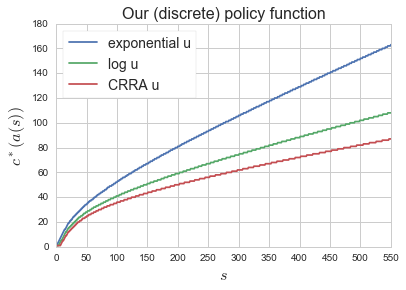

In [39]:
plt.plot(range(n),np.arange(n)-p_qe, label='exponential u')
plt.plot(range(n),np.arange(n)-log_p, label='log u')
plt.plot(range(n),np.arange(n)-crra_p, label='CRRA u')
plt.xlim(0,n-1)
plt.xticks(range(0,600,50))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$c^*(a(s))$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)

plt.show()

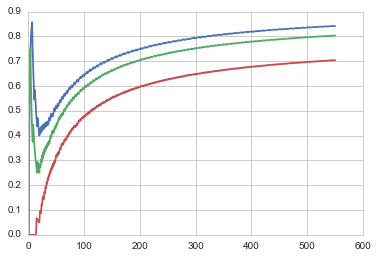

In [40]:
plt.plot(np.arange(n),crra_p/np.arange(n))
plt.plot(np.arange(n),log_p/np.arange(n))
plt.plot(np.arange(n),p_qe/np.arange(n))
plt.show()

Increasing the spread

In [29]:
Bn=100            # posible cookie returns
B0 = -25         # minimun value
B1 = 75          # max value
M=500            # Upper Storage limit of the jar
n2 = B1 + M + 1    # Number of possible states (s)
m = M + 1        # Number of posible actions (a, cookies to leave in the jar)

beta=0.9         # Discount factor
R2 = np.empty((n2, m))
Rlog = np.empty((n2, m))
Q2 = np.zeros((n2, m, n2))

    
# Rebuild matrix R
for s in range(n2):
    for a in range(m):
        if a <= s:
            R2[s, a] = CRRA(s - a, 1.5)
            Rlog[s, a] = CRRA(s - a, 1)
        else:
            R2[s, a] = -np.inf
            Rlog[s, a] = -np.inf

for a in range(m):
    if a>=-B0:
        Q2[:, a, a+B0:(a + B1 + 1)] = 1.0 / (Bn + 1)
    else:
        Q2[:, a, 1:(a + B1 + 1)] = 1.0 / (Bn + 1)
        Q2[:, a, 0] = (1.0 / (Bn + 1)) * (np.abs(a+B0)+1)

In [10]:
M + B1 + 1

551

In [30]:
Bn=100            # posible cookie returns
B0 = -25         # minimun value
B1 = 50          # max value
M=500            # Upper Storage limit of the jar
n2 = B1 + M + 1    # Number of possible states (s)
m = M + 1        # Number of posible actions (a, cookies to leave in the jar)

beta=0.9         # Discount factor
R2 = np.empty((n2, m))
Rlog = np.empty((n2, m))
Q2 = np.zeros((n2, m, n2))

    
# Rebuild matrix R
for s in range(n2):
    for a in range(m):
        if a <= s:
            R2[s, a] = CRRA(s - a, 1.5)
            Rlog[s, a] = CRRA(s - a, 1)
        else:
            R2[s, a] = -np.inf
            Rlog[s, a] = -np.inf

for a in range(m):
    if a>=-B0:
        Q2[:, a, a+B0:(a + B1)] = 1.0 / (Bn + 1)
        Q2[:, a, a + B1] = (1.0 / (Bn + 1)) * ((-B0)+1)
    else:
        Q2[:, a, 1:(a + B1)] = 1.0 / (Bn + 1)
        Q2[:, a, a + B1] = (1.0 / (Bn + 1)) * ((-B0)+1)
        Q2[:, a, 0] = (1.0 / (Bn + 1)) * (np.abs(a+B0)+1)

In [25]:
Q3 = np.zeros((n2, m, n2))
for a in range(m):
    if a>=-B0:
        Q3[:, a, a+B0:(a + B1)] = 1.0 / (75 + 1)
        Q3[:, a, a + B1] = 1 - np.sum(Q3[0, a, a+B0:(a + B1)])
    else:
        Q3[:, a, 1:(a + B1)] = 1.0 / (75 + 1)
        Q3[:, a, a + B1] = (1 - np.sum(Q3[0, a, 1:(a + B1)])) / 2
        Q3[:, a, 0] = (1 - np.sum(Q3[0, a, 1:(a + B1)])) / 2

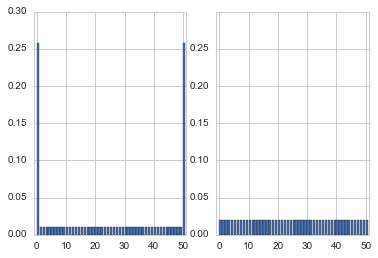

In [41]:
plt.subplot(121)
plt.bar(range(n2),Q2[0,0])
plt.xlim(-1,51)

plt.subplot(122)
plt.bar(range(n2),Q[0,0])
plt.xlim(-1,51)
plt.ylim(0,0.3)
plt.show()

In [27]:
crra_risky = qe.markov.DiscreteDP(R2, Q2, beta)
crra_risky_results = crra_risky.solve(method='policy_iteration')
crra_vrisky = crra_risky_results.v
crra_prisky = crra_risky_results.sigma

In [31]:
crra_morerisky = qe.markov.DiscreteDP(R2, Q3, beta)
crra_morerisky_results = crra_morerisky.solve(method='policy_iteration')
crra_vmorerisky = crra_morerisky_results.v
crra_pmorerisky = crra_morerisky_results.sigma

In [28]:
log_risky = qe.markov.DiscreteDP(Rlog, Q2, beta)
log_risky_results = log_risky.solve(method='policy_iteration')
log_vrisky = log_risky_results.v
log_prisky = log_risky_results.sigma

In [32]:
log_morerisky = qe.markov.DiscreteDP(Rlog, Q3, beta)
log_morerisky_results = log_morerisky.solve(method='policy_iteration')
log_vmorerisky = log_morerisky_results.v
log_pmorerisky = log_morerisky_results.sigma

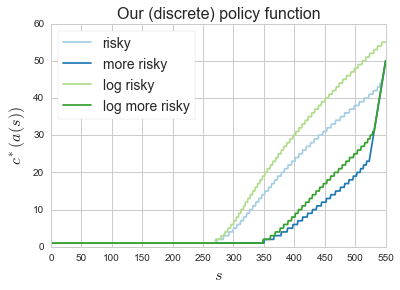

In [34]:
sns.set_palette(sns.color_palette("Paired"))
#plt.plot(range(n),np.arange(n)-p_qe, label='exponential u')
#plt.plot(range(n),np.arange(n)-log_p, label='log u')
#plt.plot(range(n),np.arange(n)-crra_p, label='original')
plt.plot(range(n2),np.arange(n2)-crra_prisky, label='risky')
plt.plot(range(n2),np.arange(n2)-crra_pmorerisky, label='more risky')
plt.plot(range(n2),np.arange(n2)-log_prisky, label='log risky')
plt.plot(range(n2),np.arange(n2)-log_pmorerisky, label='log more risky')
plt.xlim(0,n-1)
plt.xticks(range(0,600,50))
plt.title('Our (discrete) policy function', fontsize=16)
plt.ylabel('$c^*(a(s))$', fontsize=16)
plt.xlabel('$s$', fontsize=16)
plt.legend(loc='best', frameon=True, fontsize=14)

plt.show()

In [75]:
n

551